In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

In [3]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.extraction.rois as roiutils

import analyze2p.correlations as cr

In [4]:
%matplotlib notebook

In [5]:
# import allensdk as ak
import analyze2p.correlations as cr


# Plotting

In [6]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)

#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

# Source

In [7]:
experiment = 'gratings'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=500
n_resamples=20
print(responsive_test, responsive_thr)

#### Responsive params
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters) #, 
#                             n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

ROC 0.05
traces001|fit-dff_responsive-ROC-thr0.05_boot-500


# Output dir

In [8]:
dst_dir = os.path.join(aggregate_dir, 'gratings-tuning', 
                       '%s-%s' % (traceid, ori_fit_desc))
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500


# Load metadata

In [9]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())


/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
|    |   visual_area |
|:---|--------------:|
| Li |            16 |
| Lm |            10 |
| V1 |             9 |


In [10]:
'20190306_JC061_fov2' in sdata['datakey'].values

True

# Load fits

In [11]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, 
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
gdata.head()

... [20190314_JC070_fov1] No ori_dir
... [20190315_JC070_fov2] No ori_dir
... [20190319_JC067_fov1] No ori_dir
... [20190321_JC070_fov2] No ori_dir
... [20190522_JC089_fov1] No ori_dir
... [20190527_JC092_fov3] No ori_dir
... [20190602_JC091_fov1] No ori_dir
... [20190606_JC091_fov1] No ori_dir
... [20190607_JC091_fov1] No ori_dir
... [20190609_JC099_fov1] No ori_dir
... [20190612_JC099_fov1] No ori_dir
... [20190614_JC091_fov1] No ori_dir
... [20190617_JC099_fov1] No ori_dir
... [20191018_JC113_fov1] No ori_dir
... [20191105_JC117_fov1] No ori_dir
... [20191111_JC120_fov1] No ori_dir
... [20190306_JC061_fov2] No ori_dir
... [20190512_JC083_fov1] No ori_dir
... [20190513_JC078_fov1] No ori_dir
... [20190517_JC083_fov1] No ori_dir
... [20190525_JC084_fov1] No ori_dir
... [20190603_JC080_fov1] No ori_dir
... [20190618_JC097_fov1] No ori_dir
... [20190627_JC091_fov1] No ori_dir
... [20191105_JC117_fov1] No ori_dir
... [20191111_JC120_fov1] No ori_dir
... [20190511_JC083_fov1] No ori_dir
.

ValueError: No objects to concatenate

In [10]:
print("Filter by combined R2:")
print(gdata[gdata['r2comb']>=0.5][['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())

print("Filter by Goodness-of-Fit thr:")
print(gdata[gdata['gof']>=0.5][['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())


Filter by combined R2:
|    |   visual_area |
|:---|--------------:|
| V1 |           492 |
| Lm |           422 |
| Li |           160 |
Filter by Goodness-of-Fit thr:
|    |   visual_area |
|:---|--------------:|
| V1 |           341 |
| Lm |           293 |
| Li |            98 |


# Load trial data

In [11]:
trial_epoch='stimulus' #'stimulus'
experiment='gratings'
NDATA0 = aggr.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, verbose=False,
                      responsive_thr=responsive_thr, n_stds=n_stds)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


#### Filter fits

In [12]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
        .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg.groupby(['visual_area']).count()

old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
bestg = hutils.split_datakey(bestg)
# bestg = bestg[~bestg.animalid.isin(old_rats)]
# bestg[bestg.visual_area=='Li']['datakey']
print(bestg[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |           686 |
| Lm |           619 |
| Li |           261 |


In [13]:
%matplotlib notebook

In [14]:
# Assign "preferred theta" for tested values
theta_vals = np.linspace(0, 360, 9)
print(theta_vals)
bestg['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)== np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in bestg['theta_pref'].values]
bestg['tested_theta'] = bestg['tested_theta'].astype(float)

[  0.  45.  90. 135. 180. 225. 270. 315. 360.]


In [15]:
# Drop repeat FOVs based on N fits
fit_thr=0.5
counts = bestg[bestg['gof']>=fit_thr][['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = aggr.drop_repeats(counts)
NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
print(NDATA[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())


|    |   visual_area |
|:---|--------------:|
| V1 |           823 |
| Lm |           723 |
| Li |           236 |


In [16]:
gdata_u = pd.concat([g for (va, dk), g in bestg.groupby(['visual_area', 'datakey'])
                    if (va, dk) in u_dkeys])
print(gdata_u['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |           685 |
| Lm |           609 |
| Li |           196 |


In [19]:
%matplotlib inline

|    |   visual_area |
|:---|--------------:|
| V1 |           340 |
| Lm |           288 |
| Li |            76 |


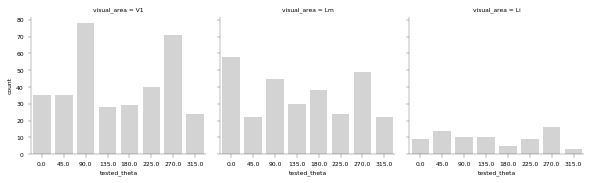

In [20]:
gof_thr=0.5
final_dkeys = [u[1] for u in u_dkeys]
final_fits = bestg[(bestg['gof']>=gof_thr) 
                 & (bestg.datakey.isin(final_dkeys))].copy()
print(final_fits['visual_area'].value_counts().to_markdown())

sns.catplot(x='tested_theta', col='visual_area', data=final_fits, kind='count',
            height=2.75, col_order=visual_areas, color='lightgrey')
pl.subplots_adjust(bottom=0.2, left=0.05)

# Aggregate metrics

In [21]:
#### Set current output dir
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics


### Signal corrs

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [23]:
# def calculate_corrs(ndf, return_zscored=False, curr_cells=None, curr_cfgs=None):
#     if curr_cells is None: 
#         curr_cells = ndf['cell'].unique()
#     if curr_cfgs is None:
#         curr_cfgs = ndf['config'].unique()
#     ndf1 = ndf[(ndf.config.isin(curr_cfgs)) & (ndf['cell'].isin(curr_cells))].copy()
#     # Reshape dataframe to ntrials x nrois
#     trial_means0 = aggr.stacked_neuraldf_to_unstacked(ndf1)
#     cfgs_by_trial = trial_means0['config']
#     # Zscore trials
#     zscored = aggr.zscore_dataframe(trial_means0[curr_cells])
#     zscored['config'] = cfgs_by_trial
#     # Get signal correlations
#     signal_corrs = calculate_signal_corrs(zscored)
#     # Get Noise correlations
#     noise_corrs0 = calculate_noise_corrs(zscored)
#     # Average over stimulus conditions 
#     noise_corrs = noise_corrs0.groupby(['neuron_pair']).mean().reset_index()
#     # Combine
#     corrs = pd.merge(signal_corrs, noise_corrs)
#     if return_zscored:
#         return corrs, zscored
#     else:
#         return corrs

# def calculate_signal_corrs(zscored, included_configs=None):
#     ''' Calculate signal correlations.
#     Signal correlations are computed as the Pearson correlation between
#     trial-averaged stimulus responses for pairs of neurons.
#     Get pairwise CC for condition vectors (each point is a cond, avg across trials).
    
#     zscored (pd.DataFrame): 
#         Unstacked, zscored NDATA for easy column-wise ops.
#         Columns are cells + config, rows are trials
        
#     Returns: cc (pd.DataFrame)
#         columns: cell_1, cell_2, neuron_pair, and correlation coeff. 
    
#     Note: Faster than itertools method.
#           8.91 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
#     '''
#     if included_configs is None:
#         included_configs = zscored['config'].unique()
        
#     # Each entry is the mean response (across trials) for a given stim condition.
#     # tuning_ : df, nconds x nrois
#     zscored.index.name = None
#     zscored.columns.name = None
#     tuning_ = zscored[zscored['config'].isin(included_configs)]\
#                                    .groupby(['config']).mean().reset_index()
#     # columns are cells, rows are stimuli -- get pairwise corrs()
#     cc = do_pairwise_cc_melt(tuning_, metric_name='signal_cc')
    
#     return cc


# def calculate_noise_corrs(zscored, method='pearson'):
#     ''' Calculate noise correlations.
#     Noise correlations are computed as the Pearson correlation of single-trial 
#     responses of a given stimulus condition for a pair of neurons, then 
#     averaged over stimuli.
    
#     For each condition, get pairwise CC for trial vectors (each point is a trial).
#     Should average across conditions to get 1 noise CC per neuron pair.
    
#     zscored (pd.DataFrame): 
#         Unstacked, zscored NDATA for easy column-wise ops.
#         Columns are cells + config, rows are trials
        
#     Returns: cc (pd.DataFrame)
#         columns: cell_1, cell_2, neuron_pair, and correlation coeff. 
    
#     Note: Faster than itertools method.
#           8.91 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
#     '''
#     c_=[]
#     for cfg, df_ in zscored.groupby(['config']):
#         df_.index.name = None
#         df_.columns.name = None
#         # columns are cels, rows are trials (for 1 condition)
#         cc_ = do_pairwise_cc_melt(df_, metric_name='noise_cc', 
#                                   include_diagonal=False)
#         cc_['config'] = cfg
#         c_.append(cc_)
#     cc = pd.concat(c_, axis=0)
#     return cc

# def do_pairwise_cc_melt(df_, metric_name='cc', include_diagonal=False):
#     '''Do pairwise correltion betwen all pairs of columns.
#     Get unique pairs' values from correlation matrix'''
#     cc = melt_square_matrix(df_.corr(), metric_name=metric_name, 
#                             include_diagonal=include_diagonal)
#     cc = cc.rename(columns={'row': 'cell_1', 'col': 'cell_2'})
#     cc['neuron_pair'] = ['%i_%i' % (c1, c2) for \
#                          c1, c2 in cc[['cell_1', 'cell_2']].values]
#     return cc
    
# def melt_square_matrix(df, metric_name='value', add_values={}, include_diagonal=False):
#     '''Melt square matrix into unique values only'''
#     k = 0 if include_diagonal else 1
#     df = df.where(np.triu(np.ones(df.shape), k=k).astype(np.bool))

#     df = df.stack().reset_index()
#     df.columns=['row', 'col', metric_name]

#     if len(add_values) > 0:
#         for k, v in add_values.items():
#             df[k] = [v for _ in np.arange(0, df.shape[0])]

#     return df

# def trial_averaged_responses(zscored, sdf, params=['ori', 'sf', 'size', 'speed']):
#     '''
#     Average all trials for each condition. 
#     Params should list stimulus configs (in sdf) 
    
#     Returns:
    
#     tuning_ : pd.DataFrame
#         Trial-averaged repsonses. Columns are cells, rows are stimulus conds.
#     '''
#     # Get mean response per condition (columns=cells, rows=conditions)
#     tuning_ = zscored.groupby(['config']).mean().reset_index()
#     ctuples = tuple(sdf[params].values)
#     multix = pd.MultiIndex.from_tuples(ctuples, names=params)
#     tuning_.index = multix

#     return tuning_

In [24]:
# # https://stackoverflow.com/questions/58854335/how-to-label-y-ticklabels-as-group-category-in-seaborn-clustermap
# from itertools import groupby    
# def add_line(ax, xpos, ypos, offset=0.2, lw=1):
#     line = pl.Line2D([ypos, ypos+ offset], [xpos, xpos], color='black', 
#                      transform=ax.transAxes, linewidth=lw)
#     line.set_clip_on(False)
#     ax.add_line(line)

# def label_len(my_index,level):
#     labels = my_index.get_level_values(level)
#     return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

# def label_group_bar_table(ax, df, offset=0.2, lw=1):
#     xpos = -offset
#     scale = 1./df.index.size
#     for level in range(df.index.nlevels):
#         pos = df.index.size
#         for label, rpos in label_len(df.index,level):
#             add_line(ax, pos*scale, xpos, offset=offset, lw=lw)
#             pos -= rpos
#             lypos = (pos + .5 * rpos)*scale
#             ax.text(xpos+(offset*0.5), lypos, label, ha='center', transform=ax.transAxes) 
#         add_line(ax, pos*scale , xpos)
#         xpos -= offset

# Example FOV & CELL

In [30]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [31]:
va = 'V1'
dk='20190617_JC097_fov1'
selective_only=False

ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# Select cells
if selective_only:
    curr_cells = gdata_u[(gdata_u.visual_area==va) 
                    & (gdata_u.datakey==dk)]['cell'].unique()
    if len(curr_cells)<5:
        print("Skipping.")
        #continue
else:
    curr_cells = ndf['cell'].unique()
    
# Select stimuli and trials
sdf = aggr.get_stimuli(dk, experiment='gratings')
curr_cfgs = sdf.index.tolist()
corrs, zscored = cr.calculate_corrs(ndf, return_zscored=True,
                                 curr_cells=curr_cells, curr_cfgs=curr_cfgs)
# Get mean response per condition (columns=cells, rows=conditions)
params=['ori', 'sf', 'size', 'speed']
tuning_ = cr.trial_averaged_responses(zscored, sdf, params=params)
rois_ = [i for i in tuning_.columns if hutils.isnumber(i)]

#### Representational Similarity Matrix

In [32]:
sdf['tf'] = sdf['sf']*sdf['speed']
xlabels = ['%i|%.2f|%i|%i' % (o, sf, sz, sp) for (o, sf, sz, sp) in \
           sdf.loc[tuning_['config']][['ori', 'sf', 'size', 'speed']].values]

mat_ = tuning_[rois_].T.corr(method='spearman')
msk_ = np.triu(np.ones_like(mat_, dtype=bool))

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20 example_rdm__20190617_JC097_fov1


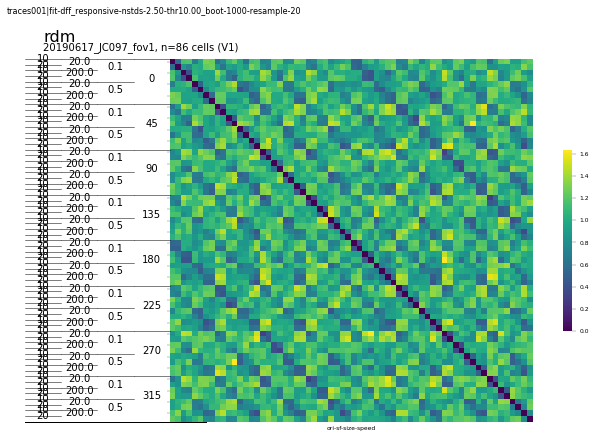

In [34]:
plot_rdm = True

if plot_rdm:
    pmat = 1-mat_
    cmap='viridis' # 0=totally same, 2+ more dissimilar
    plot_name = 'rdm'
else:
    pmat = mat_.copy()
    cmap = 'RdBu_r' # red, corr=1, blue, anticorr=-1
    plot_name = 'corr'
    
fig, ax = pl.subplots(1,1,figsize=(10, 6))
sns.heatmap(pmat, cmap=cmap, ax=ax, #mask=msk_, 
            square=True, cbar_kws={"shrink": 0.5})

#ax.set_aspect('equal')
fig.text(0.05, 0.9, '%s, n=%i cells (%s)' % (dk, len(rois_), va))

#Below 3 lines remove default labels
labels = ['' for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.set_ylabel('')
ax.set_xticks([])

pplot.label_group_bar_table(ax, mat_, offset=0.1, lw=0.5)
fig.subplots_adjust(bottom=.01*mat_.index.nlevels, left=0.05, right=0.9)
fig.text(0.05, 0.92, plot_name, fontsize=16)

pplot.label_figure(fig, data_id)

figname = 'example_%s__%s' % (plot_name, dk)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [35]:
tuning_.head()

config         0         1         2         3  \
ori sf  size  speed                                                      
0   0.1 20.0  10     config001  0.153151  0.329558  0.224440  0.179428   
              20     config002 -0.057959  0.035856 -0.052851  0.019106   
        200.0 10     config003 -0.134567 -0.320522 -0.282281 -0.380093   
              20     config004 -0.324717 -0.399886 -0.570506 -0.609093   
    0.5 20.0  10     config005 -0.004157 -0.015564  0.641289 -0.204073   

                            5        20        21        22        25  ...  \
ori sf  size  speed                                                    ...   
0   0.1 20.0  10     0.028163  0.182997  0.476894  0.384818  0.323339  ...   
              20    -0.098306 -0.211365  0.184768 -0.179077  0.111997  ...   
        200.0 10    -0.115864  0.059393  0.210067 -0.298661 -0.213385  ...   
              20    -0.277105 -0.128887 -0.415334 -0.647450 -0.391901  ...   
    0.5 20.0  10    -0.048154  0.056552  0.026834  0.080210  0.054714  ...   

                          292       311       324       361       377  \
ori sf  size  speed                                                     
0   0.1 20.0  10     0.067957  0.104507  0.163431  0.010911 -0.649265   
              20    -0.374266 -0.246596  0.197352 -0.180331 -0.160284   
        200.0 10    -0.168262 -0.051735 -0.339523 -0.271949  0.827831   
              20    -0.076303 -0.142967 -0.128427 -0.552509  0.471889   
    0.5 20.0  10     0.308225  0.033728  0.116375 -0.158607 -0.242895   

                          396       399       428       430       435  
ori sf  size  speed                                                    
0   0.1 20.0  10     1.173619 -0.307921  0.528897  0.526549 -0.146655  
              20     0.462354 -0.252587 -0.050213 -0.406933  0.351873  
        200.0 10    -0.228530 -0.467539 -0.053980 -0.421863 -0.102173  
              20    -0.346628 -0.324166 -0.459907 -0.516850 -0.380848  
    0.5 20.0  10    -0.144695 -0.115073  0.211042  0.135424  0.142314  

[5 rows x 87 columns]

In [36]:
n_nonori_cfgs = sdf[['sf', 'size', 'speed']].drop_duplicates().shape[0]
n_nonori_cfgs

8

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20 example_split_rdm__20190617_JC097_fov1


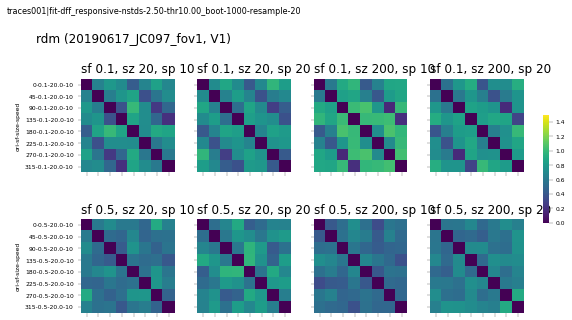

In [37]:
if plot_rdm:
    vmin=0; vmax=1.5;
    cmap='viridis'
    plot_name = 'rdm'
else:
    vmin=-1; vmax=1;
    cmap='RdBu_r'
    plot_name='corr'
    
idx = pd.IndexSlice
fig, axn = pl.subplots(2, 4, figsize=(8,5))
cbar_ax = fig.add_axes([0.93, 0.4, 0.01, 0.3])
ai=0
for (sf, sz, sp), g in sdf.groupby(['sf', 'size', 'speed']):
    ax=axn.flat[ai]
    mat = tuning_.loc[idx[:, [sf], [sz], [sp]]][rois_].T.corr()
    pmat = 1-mat if plot_rdm else mat.copy()
    im = sns.heatmap(pmat, ax=ax, square=True, cmap=cmap,
                    vmin=vmin, vmax=vmax,
                    cbar=ai==0, cbar_ax=None if ai else cbar_ax) 
    ax.set_aspect('equal')
    ax.set_title('sf %.1f, sz %i, sp %i' % (sf, sz, sp), loc='left')
    ai+=1
    
for ai, ax in enumerate(axn.flat):
    ax.set_xticklabels([])
    ax.set_xlabel('')
    if ai==0 or ai==4:
        continue
    ax.set_ylabel('')
    ax.set_yticklabels([])

pl.subplots_adjust(wspace=0.2, hspace=0.5, bottom=0.15, top=0.8)

fig.text(0.05, 0.9, '%s (%s, %s)' % (plot_name, dk, va), fontsize=12)
pplot.label_figure(fig, data_id)

figname = 'example_split_%s__%s' % (plot_name, dk)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


## Correlations

In [38]:
# def get_pw_cortical_distance(cc_, pos_):
#     # Get current FOV rfdata and add position info to sigcorrs df
#     r1 = cc_['cell_1'].unique()
#     r2 = cc_['cell_2'].unique()
#     crois_ = np.union1d(r1, r2)
#     assert len([r for r in crois_ if r not in pos_.index.tolist()])==0, \
#         "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
#     if 'cell' in pos_.columns:
#         pos_.index = pos_['cell'].values
#     # Coords of cell1 in pair, in order
#     coords1 = np.array(pos_.loc[cc_['cell_1'].values][['ml_pos', 'ap_pos']])
#     # Coords of cell2 in pair 
#     coords2 = np.array(pos_.loc[cc_['cell_2'].values][['ml_pos', 'ap_pos']])
#     # Get dists, in order of appearance
#     dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
#     cc_['cortical_distance'] = dists
    
#     return cc_

# def bin_column_values(cc_, to_quartile='cortical_distance', use_quartile=True,
#                      n_bins=4):
#     '''
#     Split column into quartiles (n_bins=4) or custom N bins.
#     to_quartile: str
#         Column to bin
#     use_quartile: bool
#         Set to use quartiles (evenly populated bins), otherwise, use even sized bins
#     n_bins: int
#         Number of bins
#     '''
#     # print("binning: %s" % bin_type)
#     if use_quartile:
#         cc_['binned_%s' % to_quartile], bin_edges = pd.qcut(cc_[to_quartile], \
#                                         n_bins_dist, labels=False, retbins=True)
#     else:
#         cc_['binned_%s' % to_quartile], bin_edges = pd.cut(cc_[to_quartile], \
#                                          n_bins_dist,labels=False, retbins=True)
#     return cc_

# def plot_quartiles_vs_distance(cc_, to_quartile='cortical_distance',
#                               plot_bins=[0, 3], metric='signal_cc',
#                               qcolors=None, plot_median=True):
#     if qcolors is None:
#         nb = len(plot_bins)
#         qcolor_list = sns.color_palette('cubehelix', n_colors=nb)
#         qcolors = dict((k, v) for k, v in zip(np.arange(0, nb), qcolor_list))
        
#     currd = cc_[cc_['binned_%s' % to_quartile].isin(plot_bins)]
#     g = sns.displot(data=currd, x=metric,
#                 hue='binned_%s' % to_quartile, legend=True, palette=qcolors)
    
#     if plot_median:
#         for b in plot_bins:
#             median_ = cc_[cc_['binned_%s' % to_quartile]==b][metric].median()
#             g.fig.axes[0].axvline(x=median_, color=qcolors[b])
#     # g.fig.axes[0].axvline(x=0, color='k')
#     return g

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


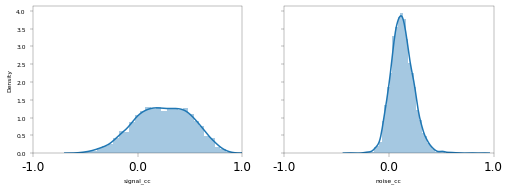

In [39]:
fig, axn = pl.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
sns.distplot(corrs['signal_cc'], ax=axn[0])
sns.distplot(corrs['noise_cc'], ax=axn[1])
for ax in axn.flat:
    ax.set_xlim([-1, 1])
    ax.set_xticks(np.linspace(-1, 1, 3))
    ax.set_xticklabels(np.linspace(-1, 1, 3), fontsize=12)
pl.subplots_adjust(bottom=0.2, left=0.1)

#### Load spatial info

In [48]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [42]:
session, animalid, fovnum = hutils.split_datakey_str(dk)
fov = 'FOV%i_zoom2p0x' % fovnum

# Position info
rois_ = ndf['cell'].unique()
fcoords = roiutils.get_roi_coords(animalid, session, fov, traceid=traceid)
pos_ = fcoords['roi_positions'].loc[rois_].copy()

In [44]:
# Add cortical distances
cc_ = corrs.copy()
cc_ = cr.get_pw_cortical_distance(cc_, pos_)
cc_['visual_area'] = va
cc_['datakey'] = dk
cc_.head()

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey
0,0,1,0.825588,0_1,0.787772,14.677900,V1,20190617_JC097_fov1
1,0,2,0.129426,0_2,-0.173906,53.353902,V1,20190617_JC097_fov1
2,0,3,0.357507,0_3,0.204957,79.267714,V1,20190617_JC097_fov1
3,0,5,0.054770,0_5,-0.015376,40.316287,V1,20190617_JC097_fov1
4,0,20,0.080864,0_20,0.223760,149.931500,V1,20190617_JC097_fov1


|   binned_cortical_distance |   cortical_distance |   signal_cc |
|---------------------------:|--------------------:|------------:|
|                          0 |             160.721 |    0.317638 |
|                          1 |             329.919 |    0.259252 |
|                          2 |             471.872 |    0.248466 |
|                          3 |             699.822 |    0.143203 |


|   binned_cortical_distance |   cortical_distance |   noise_cc |
|---------------------------:|--------------------:|-----------:|
|                          0 |             160.721 |  0.163718  |
|                          1 |             329.919 |  0.141407  |
|                          2 |             471.872 |  0.121179  |
|                          3 |             699.822 |  0.0861741 |
First and Last ~cortical_distance~ quartiles, diff <noise_cc> = -0.07
example_noise_cc_byquartile_cortical_distance


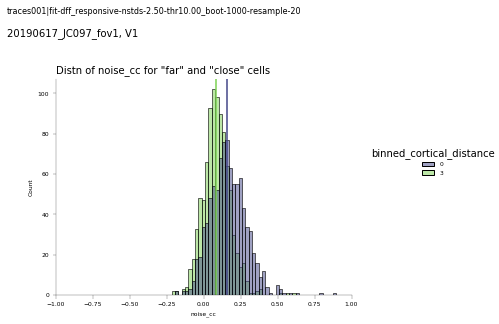

In [69]:
n_bins=4
use_quartile=True
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
qcolors = dict((k, v) for k, v in zip(np.arange(0, n_bins), qcolor_list))
# Bin into quartiles
to_quartile='cortical_distance'
cc_ = cr.bin_column_values(cc_, to_quartile=to_quartile, use_quartile=use_quartile,
                     n_bins=n_bins)
# Plot metric X for top and bottom quartiles
metric = 'noise_cc'
plot_bins = [0,3] # [0, 1, 2, 3]
print(cc_.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]].mean().to_markdown())

g = cr.plot_quartiles_vs_distance(cc_, to_quartile=to_quartile,
                              plot_bins=plot_bins, metric=metric,
                              qcolors=qcolors)
pl.subplots_adjust(bottom=0.2)
g.fig.axes[0].set_xlim([-1, 1])
# print some stuff
lo_median = cc_[cc_['binned_%s' % to_quartile]==0][metric].median()
hi_median = cc_[cc_['binned_%s' % to_quartile]==3][metric].median()
print('First and Last ~%s~ quartiles, diff <%s> = %.2f' \
          % (to_quartile, metric, hi_median - lo_median))
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
pplot.label_figure(g.fig, data_id)
g.fig.text(0.0, 0.92, '%s, %s' % (dk, va))
g.fig.axes[0].set_title('Distn of %s for "far" and "close" cells' % metric, loc='left', 
                  fontsize=10)
figname = 'example_%s_byquartile_%s' % (metric, to_quartile)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [74]:
%matplotlib notebook

In [73]:
# RF info
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
rfs_ = combined_rfs[(combined_rfs.visual_area==va) & (combined_rfs.datakey==dk)
                   & (combined_rfs['cell'].isin(rois_))].copy()
rfs_.index = rfs_['cell'].values

# Get rf overlaps
rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
overlaps_ = rfutils.get_rf_overlaps(rf_polys)
overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) for c1, c2 in overlaps_[['cell_1', 'cell_2']].values]

# merge RF and CC/distance data
has_both = np.intersect1d(overlaps_['neuron_pair'], cc_['neuron_pair'])
ccrf_ = pd.merge(overlaps_[overlaps_['neuron_pair'].isin(has_both)],
               cc_[cc_['neuron_pair'].isin(has_both)])

|   binned_noise_cc |   noise_cc |   perc_overlap |
|------------------:|-----------:|---------------:|
|                 0 |  0.0954662 |       0.805774 |
|                 1 |  0.175502  |       0.840764 |
|                 2 |  0.231779  |       0.861144 |
|                 3 |  0.326     |       0.884219 |
First and Last ~noise_cc~ quartiles, diff <perc_overlap> = 0.09


<IPython.core.display.Javascript object>


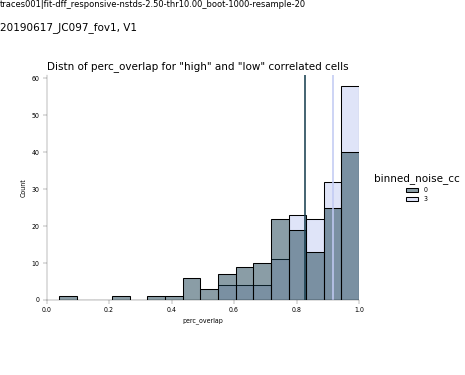

example_perc_overlap_byquartile_noise_cc


In [85]:
n_bins=4
use_quartile=True
qcolor_list = sns.color_palette('cubehelix', n_colors=n_bins)
qcolors = dict((k, v) for k, v in zip(np.arange(0, n_bins), qcolor_list))
# Bin into quartiles
to_quartile='noise_cc'
ccrf_ = cr.bin_column_values(ccrf_, to_quartile=to_quartile, use_quartile=use_quartile,
                     n_bins=n_bins)
# Plot metric X for top and bottom quartiles
metric = 'perc_overlap'
plot_bins = [0,3] # [0, 1, 2, 3]
print(ccrf_.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]].mean().to_markdown())
# print some stuff
lo_median = ccrf_[ccrf_['binned_%s' % to_quartile]==0][metric].median()
hi_median = ccrf_[ccrf_['binned_%s' % to_quartile]==3][metric].median()
print('First and Last ~%s~ quartiles, diff <%s> = %.2f' \
          % (to_quartile, metric, hi_median - lo_median))

g = cr.plot_quartiles_vs_distance(ccrf_, to_quartile=to_quartile,
                              plot_bins=plot_bins, metric=metric,
                              qcolors=qcolors)
pl.subplots_adjust(bottom=0.2)
g.fig.axes[0].set_xlim([0, 1])


pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
pplot.label_figure(g.fig, data_id)
g.fig.text(0.0, 0.92, '%s, %s' % (dk, va))
g.fig.axes[0].set_title('Distn of %s for "high" and "low" correlated cells'\
                    % metric, loc='left', fontsize=10)
figname = 'example_%s_byquartile_%s' % (metric, to_quartile)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

#### Compare Signal vs Noise Correlations

In [128]:
gof_thr=0.5
passg = bestg[(bestg['gof']>=gof_thr) 
                 & (bestg.datakey.isin(final_dkeys))].copy()

In [129]:
va, dk

('V1', '20190617_JC097_fov1')

In [130]:
currfits = passg[(passg.visual_area==va) & (passg.datakey==dk)].copy()

sorter=['gof', 'r2comb']
top5 = currfits.sort_values(by=sorter, ascending=False)\
        [['gof', 'r2', 'response_pref', 'tf', 'cell']].iloc[0:5]['cell'].values
bottom5 = currfits.sort_values(by=sorter, ascending=True)\
        [['gof', 'r2', 'response_pref', 'tf', 'cell']].iloc[0:5]['cell'].values

<IPython.core.display.Javascript object>


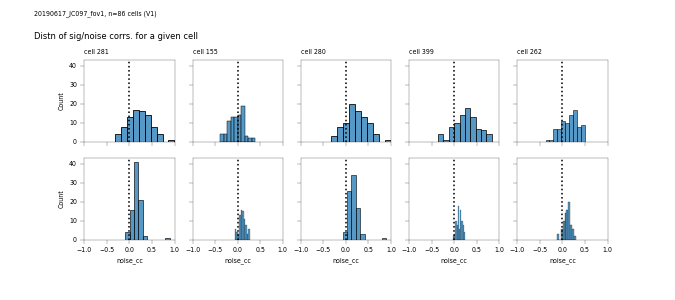

In [137]:
fig, axn = pl.subplots(2, 5, figsize=(9,4), sharex=True, sharey=True)

for ai, ri, in enumerate(top5):
    ax=axn[0, ai]
    ax.set_title('cell %i' % ri, loc='left', fontsize=6)
    currd = corrs[
                (corrs['cell_1']==ri) | (corrs['cell_2']==ri)].copy()
    sns.histplot(x='signal_cc', data=currd, ax=ax, bins=10)
    ax=axn[1, ai]
    sns.histplot(x='noise_cc', data=currd, ax=ax, bins=10)
    
for ax in axn.flat:
    ax.set_xlim([-1, 1])
    ax.axvline(x=0, color='k', ls=':')
    
fig.text(0.05, 0.95, '%s, n=%i cells (%s)' % (dk, len(rois_), va))
fig.text(0.05, 0.87, 'Distn of sig/noise corrs. for a given cell', fontsize=8)

pl.subplots_adjust(bottom=0.2, top=0.8)

#### Scatter plot comparing Signal/Noise per cell

In [128]:
nplot=20
top_ = currfits.sort_values(by=sorter, ascending=False)\
        [['gof', 'r2', 'response_pref', 'tf', 'cell']].iloc[0:nplot]['cell'].values

In [129]:
currfits.head()

,asi,dsi,response_null,response_offset,response_pref,sigma,theta_pref,r2,cell,r2comb,...,sf,size,speed,visual_area,datakey,animalid,fov,session,tf,tested_theta
2775,0.195308,0.571425,0.020930,-0.021574,0.090963,74.579649,191.020408,0.853096,1.0,0.760906,...,0.1,200.0,20.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,2.0,180.0
2782,0.496438,0.252988,0.082878,-0.039848,0.102565,54.962971,88.163265,0.796958,22.0,0.710106,...,0.5,20.0,10.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,5.0,90.0
2788,0.736206,0.119156,0.041650,0.007465,0.052532,22.501239,264.489796,0.897492,37.0,0.825375,...,0.1,200.0,10.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,1.0,270.0
2799,0.552736,0.607409,0.030281,-0.001267,0.081455,37.089249,279.183673,0.788202,52.0,0.698670,...,0.1,20.0,20.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,2.0,270.0
2804,0.213157,0.491717,0.019220,-0.023134,0.056257,86.467439,315.918367,0.774580,60.0,0.719698,...,0.5,20.0,20.0,V1,20190617_JC097_fov1,JC097,FOV1_zoom2p0x,20190617,10.0,315.0


#### For the most responsive/best fit cells, compare
noise vs signal corrs

In [139]:
sorted_={}
nplot=20
for d, g in currfits.groupby(['tested_theta']):
    sorted_[d] = g.sort_values(by=sorter, ascending=False)\
                                .iloc[0:nplot]['cell'].values
sorted_

{45.0: array([100.]),
 90.0: array([280., 399., 361., 229., 125., 211.,  66.,  22.]),
 135.0: array([155., 146., 119.]),
 180.0: array([203.,   1., 291.,  91.]),
 225.0: array([262., 123., 200.,  69., 377., 111.,  65.]),
 270.0: array([281., 311.,  37., 215., 104., 216.,  52., 224., 107.]),
 315.0: array([183.,  60.])}

<IPython.core.display.Javascript object>


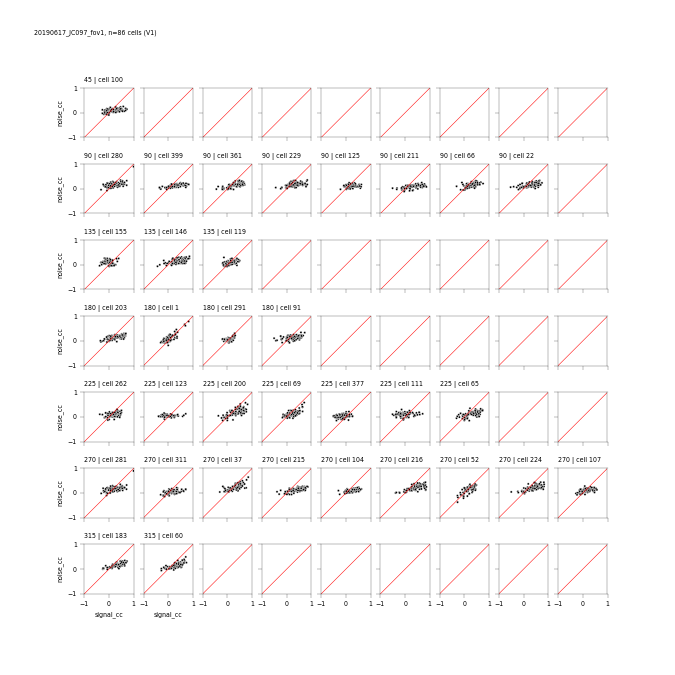

Text(0.05, 0.95, '20190617_JC097_fov1, n=86 cells (V1)')

In [140]:
ncol=max([len(v) for k, v in sorted_.items()])

fig, axn = pl.subplots(len(sorted_), ncol, figsize=(9,9), sharex=True, sharey=True)
for ai, (k, v) in enumerate(sorted_.items()):
    for ci, ri in enumerate(v):
        ax=axn[ai, ci]
        currd = corrs[(corrs['cell_1']==ri) | (corrs['cell_2']==ri)].copy()
        sns.scatterplot(x='signal_cc', y='noise_cc', data=currd, ax=ax,
                   size=1, color='k', marker='.')
        ax.set_title('%i | cell %i' % (k, ri), loc='left', fontsize=6)
        ax.legend_.remove()
pplot.equal_corr_axes(fig)

fig.text(0.05, 0.95, '%s, n=%i cells (%s)' % (dk, len(rois_), va))

# Aggregate correlation metrics

In [103]:
#### Get cell position data
NDATA['experiment'] = 'gratings'
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf = aggr.add_roi_positions(posdf)

Adding ROI position info...


In [396]:
#ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# NDATA already contains only unique dkeys
min_ncells=5
selective_only=False
c_list=[]
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    # Select cells
    if selective_only:
        rois_ = gdata_u[(gdata_u.visual_area==va) 
                        & (gdata_u.datakey==dk)]['cell'].unique()
    else:
        rois_ = ndf['cell'].unique()
    if len(rois_)<min_ncells:
        print("Skipping - (%s, %s)" % (va, dk))
        continue
    # Select stimuli and trials
    sdf = aggr.get_stimuli(dk, experiment='gratings')
    curr_cfgs = sdf.index.tolist()
    cc_, zscored = cr.calculate_corrs(ndf, return_zscored=True,
                                     curr_cells=rois_, curr_cfgs=curr_cfgs)
    # Get position info
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    cc_ = cr.get_pw_cortical_distance(cc_, pos_)
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    c_list.append(cc_)
CORRS = pd.concat(c_list)
CORRS.head()

Skipping - (Li, 20191105_JC117_fov1)
Skipping - (Li, 20191111_JC120_fov1)
Skipping - (Lm, 20191105_JC117_fov1)


,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey
0,158,160,-0.104399,158_160,-0.196600,43.356959,Li,20190314_JC070_fov1
1,158,170,-0.012260,158_170,0.095260,333.509569,Li,20190314_JC070_fov1
2,158,172,-0.136841,158_172,-0.125583,378.114923,Li,20190314_JC070_fov1
3,158,177,0.356724,158_177,-0.366026,195.919583,Li,20190314_JC070_fov1
4,158,178,-0.307577,158_178,-0.320353,248.142583,Li,20190314_JC070_fov1


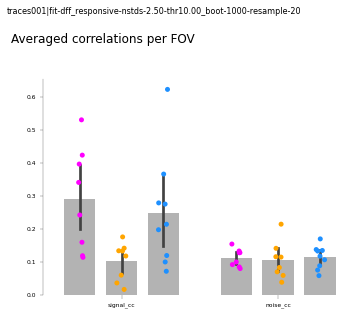

In [397]:
meancorrs = CORRS.groupby(['visual_area', 'datakey'])[['signal_cc', 'noise_cc']]\
                .mean() #.reset_index()
df_s = meancorrs.stack()\
    .rename_axis(index={'id': 'id', 'date': 'date', None: 'corr_type'})\
    .rename('corr_value').reset_index()

g = sns.FacetGrid(df_s, height=5)
g.map_dataframe(sns.stripplot, x="corr_type", y="corr_value", 
                hue="visual_area", palette=area_colors, 
                hue_order=visual_areas, dodge=True)
g.map_dataframe(sns.barplot, x="corr_type", y="corr_value", 
                hue="visual_area", palette=bw_colors, 
                hue_order=visual_areas, dodge=True)
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
pplot.change_width(g.fig.axes[0], 0.2)
sns.despine(bottom=True)

pplot.label_figure(g.fig, data_id)
g.fig.text(0.01, 0.9,'Averaged correlations per FOV', fontsize=12)

plot_type = 'selectiveonly' if selective_only else 'allcells'
figname = 'correlations_byfov_%s' % plot_type
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [265]:
CORRS.head()

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey
0,158,160,-0.104399,158_160,-0.196600,43.356959,Li,20190314_JC070_fov1
1,158,170,-0.012260,158_170,0.095260,333.509569,Li,20190314_JC070_fov1
2,158,172,-0.136841,158_172,-0.125583,378.114923,Li,20190314_JC070_fov1
3,158,177,0.356724,158_177,-0.366026,195.919583,Li,20190314_JC070_fov1
4,158,178,-0.307577,158_178,-0.320353,248.142583,Li,20190314_JC070_fov1


## Signal corrs for near vs. far cells

|               |   cortical_distance |   signal_cc |
|:--------------|--------------------:|------------:|
| ('Li', '<1')  |             137.534 |   0.310854  |
| ('Li', '1-2') |             295.885 |   0.196182  |
| ('Li', '2-3') |             433.807 |   0.142666  |
| ('Li', '>3')  |             617.627 |   0.014113  |
| ('Lm', '<1')  |             144.302 |   0.128807  |
| ('Lm', '1-2') |             300.042 |   0.0924212 |
| ('Lm', '2-3') |             446.674 |   0.0632826 |
| ('Lm', '>3')  |             708.521 |   0.0363701 |
| ('V1', '<1')  |             143.282 |   0.34271   |
| ('V1', '1-2') |             299.632 |   0.319526  |
| ('V1', '2-3') |             445.287 |   0.294985  |
| ('V1', '>3')  |             679.166 |   0.279888  |
signal_cc_byquartile_cortical_distance_aggr


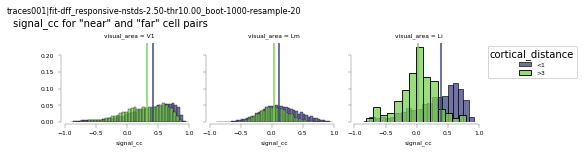

In [398]:
n_bins=4
custom_bins=False
use_quartile = False if custom_bins else True
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# Bin into quartiles
bins = [0, 200, 350, 500, 5000] if custom_bins else np.arange(0, n_bins+1).astype(int)
bin_labels = cr.custom_bin_labels(bins) #if custom_bins else bins[0:-1]
qcolors = dict((k, v) for k, v in zip(bin_labels, qcolor_list))

to_quartile='cortical_distance'
bcorrs = cr.bin_column_values(CORRS, to_quartile=to_quartile, 
                     use_quartile=use_quartile,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs.head()
# Plot metric X for top and bottom quartiles
metric = 'signal_cc'
plot_bins = [bin_labels[0], bin_labels[-1] ] # [0, 1, 2, 3]
print(bcorrs.groupby(['visual_area', 'binned_%s' \
                      % to_quartile])[[to_quartile, metric]].mean().to_markdown())

# PLOT.
currd = bcorrs[bcorrs['binned_%s' % to_quartile].isin(plot_bins)]    
g = sns.FacetGrid(data=currd, col='visual_area', col_order=visual_areas, 
                  height=2., aspect=1.3,
                  hue='binned_%s' % to_quartile, palette=qcolors) 
g.map(sns.histplot, metric, stat='probability',
     common_norm=False, common_bins=False)
g.fig.axes[-1].legend(bbox_to_anchor=(1,1), loc='upper left',
                     title=to_quartile, fontsize=6)

for (va, b), c_ in currd.groupby(['visual_area', 'binned_%s' % to_quartile]):
    median_ = c_[c_['binned_%s' % to_quartile]==b][metric].median()
    ai = visual_areas.index(va)
    g.fig.axes[ai].axvline(x=median_, color=qcolors[b])
pl.subplots_adjust(left=0.1, bottom=0.2, right=0.85, top=0.75)
sns.despine(trim=True, offset=2)
pplot.label_figure(g.fig, data_id)

g.fig.text(0.01, 0.87, '%s for "near" and "far" cell pairs' % metric, fontsize=10)

figname = '%s_byquartile_%s_aggr' % (metric, to_quartile)
print(figname)

pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

#### by fov

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[0 1 2]
|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |        1 |   0.016 | V1            |
|  1 |        0 |   0.008 | Lm            |
|  2 |        0 |   0.062 | Li            |
signal_cc_byquartile_cortical_distance_byFOV


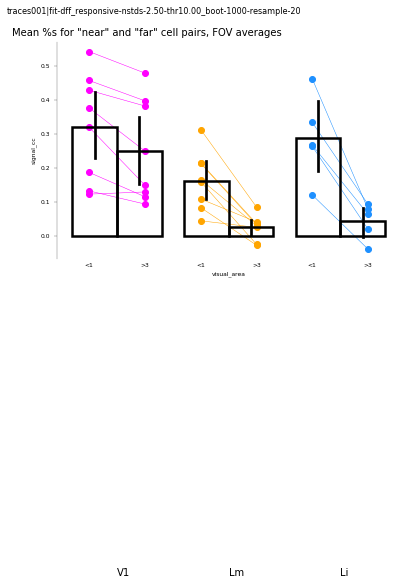

In [430]:
fovmeans = bcorrs.dropna().groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index()
means_ = pd.concat([fc for (va, dk), fc in fovmeans.dropna().groupby(['visual_area', 'datakey'])
            if len(fc)==len(bin_labels)])

currd = means_[means_['binned_%s' % to_quartile].isin(plot_bins)].copy()

fig, ax = pl.subplots()
metric='signal_cc'
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
print(pstats.to_markdown())
fig.text(0.01, 0.9, 'Mean %s for "near" and "far" cell pairs, FOV averages')

pplot.label_figure(fig, data_id)
figname = '%s_byquartile_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


signal_cc_byquartile_cortical_distance_allbins_byFOV


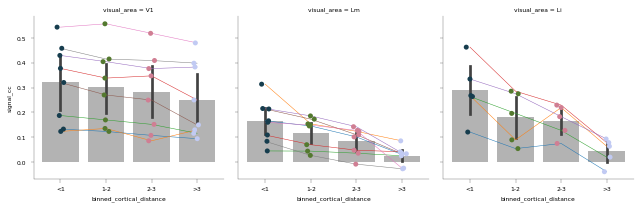

In [435]:
bw_qcolors = dict((k, [0.7]*3) for k in bin_labels)
metric = 'signal_cc'
g = sns.FacetGrid(data=means_, col='visual_area', col_order=visual_areas,
                  hue='binned_%s' % to_quartile)
g.map(sns.stripplot, 'binned_%s' % to_quartile, metric, palette='cubehelix')
g.map(sns.barplot, 'binned_%s' % to_quartile, metric, palette=bw_qcolors)

for va, fc in means_.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax = g.fig.axes[ai]
    sns.lineplot(x='binned_%s' % to_quartile, y=metric, data=fc,
                 lw=0.5, hue='datakey', ax=ax) #, linecolor='k')
    ax.legend_.remove()
    
    
fig.text(0.01, 0.9, 'Mean %s by cortical distance, FOV averages')

pplot.label_figure(fig, data_id)
figname = '%s_byquartile_%s_allbins_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

# Receptive field position?

In [295]:
# Load RF data
do_spherical_correction=False
# Get cells and metadata
assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                                experiments=['rfs', 'rfs10']) 
# Load RF fit data
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                 do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Combined rfs5/rfs10
combined_rfs = rfutils.average_rfs_select(rfdata)

N dpaths: 62, N unfit: 0
N datasets included: 62, N sessions excluded: 4


In [335]:
# Get ROI positions
rfdf = aggr.add_roi_positions(combined_rfs)
rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
rfCELLS = pd.concat([g for (va, dk), g in \
                     assigned_cells.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in rf_dkeys])

Adding ROI position info...


#### Combine GDATA and RFDATA

In [341]:
RFS=[]
GFS=[]
for (va, dk), gr_ in bestg.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf['visual_area']==va) 
                      & (rfdf['datakey']==dk)].copy()
    if len(rfs_)==0:
        continue
    rf_cells = rfs_['cell'].unique()
    gr_cells = gr_['cell'].unique()
    common_cells = np.intersect1d(rf_cells, gr_cells)
    #print('%s: %i cells in common (%s)' % (va, len(common_cells), dk))
    RFS.append(rfs_[rfs_['cell'].isin(common_cells)])
    GFS.append(gr_[gr_['cell'].isin(common_cells)])
    
RFS = pd.concat(RFS, axis=0).reset_index(drop=True)
GFS = pd.concat(GFS, axis=0).reset_index(drop=True)
print(GFS.shape, RFS.shape)
cols_to_use = RFS.columns.difference(GFS.columns)
DF = pd.merge(GFS, RFS[cols_to_use], left_index=True, right_index=True, how='outer')
print(DF['theta'].min(), DF['theta'].max())
DF['theta_deg'] = np.rad2deg(DF['theta_Mm_c'])
print(DF['theta_deg'].min(), DF['theta_deg'].max())
print(DF.dropna()['visual_area'].value_counts().to_markdown())


(501, 21) (501, 34)
0.0004899856147153087 6.282943647429465
-87.63880136750282 89.28603520427271
|    |   visual_area |
|:---|--------------:|
| V1 |           299 |
| Lm |           115 |
| Li |            87 |


In [342]:
print(rfs_[rfs_['cell'].isin(common_cells)].shape)
print(gr_[gr_['cell'].isin(common_cells)].shape)

(23, 34)
(23, 21)


In [347]:
%matplotlib inline

|    |   visual_area |
|:---|--------------:|
| V1 |           299 |
| Lm |           115 |
| Li |            87 |


Text(0.01, 0.9, 'Pref. theta for cells with both RF & gratings fits')

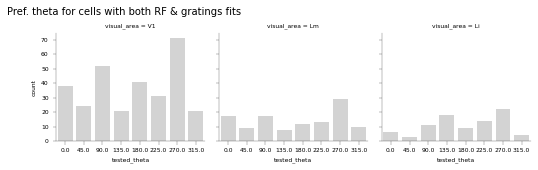

In [348]:
print(DF.dropna()['visual_area'].value_counts().to_markdown())
g = sns.catplot(x='tested_theta', col='visual_area', data=DF, kind='count',
            height=2.5, col_order=visual_areas, color='lightgrey')
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
g.fig.text(0.01, 0.9, 'Pref. theta for cells with both RF & gratings fits')

In [384]:
ndata_ccrf = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])
                       if (va, dk) in 
                        DF[['visual_area', 'datakey']].drop_duplicates().values.astype(tuple)
                       ])

In [363]:
print(ndata_ccrf[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())


|    |   visual_area |
|:---|--------------:|
| Li |            11 |
| Lm |             9 |
| V1 |             8 |


In [387]:
#ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# NDATA already contains only unique dkeys
min_ncells=5
selective_only=False
c_list=[]
for (va, dk), ndf in ndata_ccrf.groupby(['visual_area', 'datakey']):
    # Select cells
    if selective_only:
        rois_ = gdata_u[(gdata_u.visual_area==va) 
                        & (gdata_u.datakey==dk)]['cell'].unique()
    else:
        rois_ = ndf['cell'].unique()
    if len(rois_)<min_ncells:
        print("Skipping - (%s, %s)" % (va, dk))
        continue
    # Select stimuli and trials
    sdf = aggr.get_stimuli(dk, experiment='gratings')
    curr_cfgs = sdf.index.tolist()
    cc_, zscored = cr.calculate_corrs(ndf, return_zscored=True,
                                     curr_cells=rois_, curr_cfgs=curr_cfgs)
    # Get position info
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    if len(pos_)==0:
        print("No position info: %s" % dk)
        continue
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    cc_ = cr.get_pw_cortical_distance(cc_, pos_)
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    c_list.append(cc_)
CORRS = pd.concat(c_list)
CORRS.head()

No position info: 20190527_JC092_fov3
No position info: 20190606_JC091_fov1
No position info: 20190607_JC091_fov1
No position info: 20190609_JC099_fov1
Skipping - (Li, 20191105_JC117_fov1)
Skipping - (Li, 20191111_JC120_fov1)
No position info: 20190517_JC083_fov1
Skipping - (Lm, 20191105_JC117_fov1)
Skipping - (V1, 20190517_JC083_fov1)


,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey
0,158,160,-0.104399,158_160,-0.196600,43.356959,Li,20190314_JC070_fov1
1,158,170,-0.012260,158_170,0.095260,333.509569,Li,20190314_JC070_fov1
2,158,172,-0.136841,158_172,-0.125583,378.114923,Li,20190314_JC070_fov1
3,158,177,0.356724,158_177,-0.366026,195.919583,Li,20190314_JC070_fov1
4,158,178,-0.307577,158_178,-0.320353,248.142583,Li,20190314_JC070_fov1


In [386]:
pos_

,visual_area,datakey,experiment,cell,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos


In [388]:
# RF info
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
r_list=[]
for (va, dk), cc_ in CORRS.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf.visual_area==va) 
                      & (rfdf.datakey==dk)].copy()
    if len(rfs_)<min_ncells:
        print("- skipping: %s, %s" % (va, dk))
        continue
    rfs_.index = rfs_['cell'].values
    # Get rf overlaps
    rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
    overlaps_ = rfutils.get_rf_overlaps(rf_polys)
    overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
    overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) \
                                for c1, c2 in overlaps_[['cell_1', 'cell_2']].values]
    # merge RF and CC/distance data
    has_both = np.intersect1d(overlaps_['neuron_pair'], cc_['neuron_pair'])
    ccrf_ = pd.merge(overlaps_[overlaps_['neuron_pair'].isin(has_both)],
                   cc_[cc_['neuron_pair'].isin(has_both)])
    r_list.append(ccrf_)

CCRF = pd.concat(r_list, axis=0)


- skipping: Li, 20190314_JC070_fov1
- skipping: Li, 20190315_JC070_fov2
- skipping: Li, 20190319_JC067_fov1
- skipping: Lm, 20190306_JC061_fov2
- skipping: Lm, 20190314_JC070_fov2


|               |   signal_cc |   area_overlap |
|:--------------|------------:|---------------:|
| ('Li', '<1')  |   -0.189216 |       0.362829 |
| ('Li', '1-2') |    0.300308 |       0.396561 |
| ('Li', '2-3') |    0.5603   |       0.474894 |
| ('Li', '>3')  |    0.751504 |       0.562322 |
| ('Lm', '<1')  |   -0.107324 |       0.283525 |
| ('Lm', '1-2') |    0.273239 |       0.35144  |
| ('Lm', '2-3') |    0.545097 |       0.393893 |
| ('Lm', '>3')  |    0.739187 |       0.444854 |
| ('V1', '<1')  |   -0.251854 |       0.47761  |
| ('V1', '1-2') |    0.301603 |       0.467466 |
| ('V1', '2-3') |    0.563641 |       0.513982 |
| ('V1', '>3')  |    0.768386 |       0.568483 |
area_overlap_byquartile_signal_cc_aggr


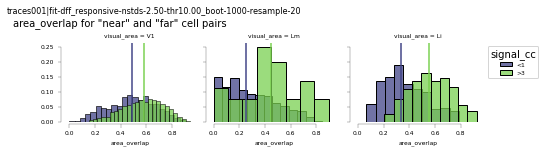

In [389]:
n_bins=4
custom_bins=False
use_quartile = False if custom_bins else True
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# Bin into quartiles
bins = [0, 200, 350, 500, 5000] if custom_bins else np.arange(0, n_bins+1).astype(int)
bin_labels = cr.custom_bin_labels(bins) #if custom_bins else bins[0:-1]
qcolors = dict((k, v) for k, v in zip(bin_labels, qcolor_list))

to_quartile='signal_cc'
bcorrs = cr.bin_column_values(CCRF, to_quartile=to_quartile, 
                     use_quartile=use_quartile,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs.head()
# Plot metric X for top and bottom quartiles
metric = 'area_overlap'
plot_bins = [bin_labels[0], bin_labels[-1] ] # [0, 1, 2, 3]
print(bcorrs.groupby(['visual_area', 'binned_%s' \
                      % to_quartile])[[to_quartile, metric]].mean().to_markdown())
# PLOT.
currd = bcorrs[bcorrs['binned_%s' % to_quartile].isin(plot_bins)]    
g = sns.FacetGrid(data=currd, col='visual_area', col_order=visual_areas, 
                  height=2., aspect=1.3,
                  hue='binned_%s' % to_quartile, palette=qcolors) 
g.map(sns.histplot, metric, stat='probability',
     common_norm=False, common_bins=False)
g.fig.axes[-1].legend(bbox_to_anchor=(1,1), loc='upper left',
                     title=to_quartile, fontsize=6)
# Add vertical lines
for (va, b), c_ in currd.groupby(['visual_area', 'binned_%s' % to_quartile]):
    median_ = c_[c_['binned_%s' % to_quartile]==b][metric].median()
    ai = visual_areas.index(va)
    g.fig.axes[ai].axvline(x=median_, color=qcolors[b])
pl.subplots_adjust(left=0.1, bottom=0.2, right=0.85, top=0.75)
sns.despine(trim=True, offset=2)
pplot.label_figure(g.fig, data_id)

g.fig.text(0.01, 0.87, '%s for "near" and "far" cell pairs' % metric, fontsize=10)

figname = '%s_byquartile_%s_aggr' % (metric, to_quartile)
print(figname)

pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/morestats.py:2984: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/morestats.py:2985: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[0 1 2]
|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |        0 |       0 | V1            |
|  1 |        0 |       0 | Lm            |
|  2 |        0 |       0 | Li            |
area_overlap_byquartile_signal_cc_byFOV


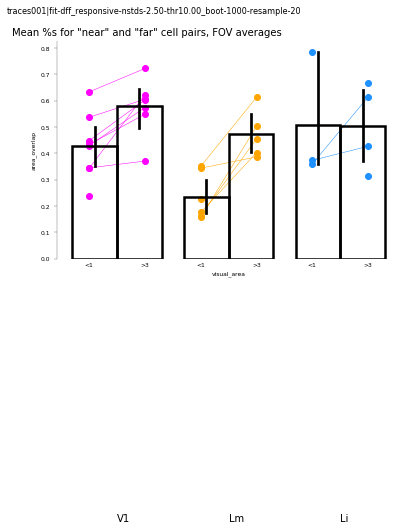

In [390]:
fovmeans = bcorrs.dropna().groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index()

currd = fovmeans[fovmeans['binned_%s' % to_quartile].isin(plot_bins)].copy()

fig, ax = pl.subplots()
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
print(pstats.to_markdown())
fig.text(0.01, 0.9, 'Mean %s for "near" and "far" cell pairs, FOV averages')

pplot.label_figure(fig, data_id)
figname = '%s_byquartile_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

In [392]:
fovmeans

,binned_signal_cc,visual_area,datakey,cell_1,cell_2,area_overlap,perc_overlap,signal_cc,noise_cc,cortical_distance
0,<1,Li,20190511_JC083_fov1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,<1,Li,20190512_JC083_fov1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,<1,Li,20190513_JC078_fov1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,<1,Li,20190522_JC084_fov1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,<1,Li,20190522_JC089_fov1,115.000000,122.000000,0.786784,0.917365,0.075189,0.268758,66.388627
...,...,...,...,...,...,...,...,...,...,...
211,>3,V1,20190618_JC097_fov1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,>3,V1,20190622_JC085_fov1,145.863014,225.082192,0.722354,0.961437,0.765381,0.166951,198.537348
213,>3,V1,20190627_JC091_fov1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,>3,V1,20191006_JC110_fov1,92.963235,183.227941,0.602680,0.923665,0.785966,0.211717,278.491669


In [378]:
DF['mod_theta'] = DF['tested_theta'] % 180.
DF['mod_theta'].min(), DF['mod_theta'].max()

(0.0, 135.0)

[  0.  45.  90. 135.]


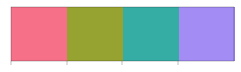

In [379]:
#colormap = 'batlow' #'nic_Edge'
#dark_cmap = pplot.darken_cmap(colormap)
color_ori=True
n_colors = 4 if color_ori else 8
color_vals = np.linspace(0, 135, 4) if color_ori else np.linspace(0, 315, 8)
print(color_vals)
theta_cmap = sns.husl_palette(n_colors) #, l=1, h=1, s=0)
# Set colors
sns.palplot(theta_cmap)
theta_colors = dict((k, v) for k, v in zip(color_vals, theta_cmap))

In [308]:
theta_vals

array([  0.,  45.,  90., 135., 180., 225., 270., 315., 360.])

{0: 'r', 315: 'r', 180: 'b', 225: 'b'}


<IPython.core.display.Javascript object>


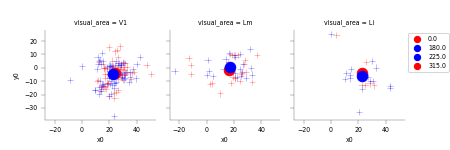

V1: nasal=(24.2, -4.1) | temporal (22.3, -4.9)
Lm: nasal=(16.7, -1.8) | temporal (17.2, 0.8)
Li: nasal=(22.8, -3.6) | temporal (22.6, -6.4)


In [311]:
# 0: Nasal, 180: Temporal
# 90: Upward, 270: Downward
nasal_color = 'r'
temporal_color='b'
nasal_ = [0, 315]
temporal_ = [180, 225]

theta_colors = dict((k, nasal_color) for k in nasal_)
theta_colors.update(dict((k, temporal_color) for k in temporal_))
print(theta_colors)

curr_oris = theta_colors.keys() #[0, 180]

currdata = DF[(DF['dsi']>=0.1) & (DF['tested_theta'].isin(curr_oris))].copy()

fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, height=2,
                   data=currdata)
fg.map(sns.scatterplot, 'x0', 'y0', 'tested_theta', #palette=theta_colors,
      alpha=0.5, palette=theta_colors, marker='+', facecolor='none')
# sns.scatterplot(x='x0', y='y0', hue='tested_theta', data=df_, ax=ax,
#                palette=theta_colors)
pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

for ai, va in enumerate(visual_areas):
    ax = fg.axes.flat[ai]
    df_ = currdata[currdata.visual_area==va].copy()
    cx_n, cy_n = hutils.CoM(df_[df_['tested_theta'].isin(nasal_)][['x0', 'y0']])
    cx_t, cy_t = hutils.CoM(df_[df_['tested_theta'].isin(temporal_)][['x0', 'y0']])
    
    ax.plot(cx_n, cy_n, color=nasal_color, marker='o', markersize=10)
    ax.plot(cx_t, cy_t, color=temporal_color, marker='o', markersize=10)

    print('%s: nasal=(%.1f, %.1f) | temporal (%.1f, %.1f)' % (va, cx_n, cy_n, cx_t, cy_t))
    

In [282]:
%matplotlib notebook

# Spatial relationship?

In [273]:
importlib.reload(aggr)

<module 'utils.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/aggregate_datasets.py'>

In [351]:
NDATA['experiment'] = 'gratings'
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf = aggr.add_roi_positions(posdf)

Adding ROI position info...


In [352]:
redo_pos = []
for (va, dk), g in posdf.groupby(['visual_area', 'datakey']):
    if len(g['ml_pos'].unique())==1:
        redo_pos.append(dk)
redo_pos

for dk in redo_pos:
    session, animalid, fovnum = hutils.split_datakey_str(dk)
    fovinfo = roiutils.get_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                                      traceid=traceid, create_new=True)

[]

In [275]:
# selective_only=False
# stimulus_type='allstim'

# assert stimulus_type in ['fullscreen', 'apertured', 'allstim']

# if stimulus_type=='fullscreen':
#     SD = fullSDF.copy()
# elif stimulus_type=='apertured':
#     SD = apSDF.copy()
# else:
#     SD = SDF.copy()
    
# roi_filter='gof%.2f' % gof_thr if selective_only else 'allcells'
# print(roi_filter)

In [471]:
min_ncells=5
selective_only=False
c_=[]
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    # ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
    # Select cells
    if selective_only:
        curr_cells = passg[(passg.visual_area==va) 
                        & (passg.datakey==dk)]['cell'].unique()
    else:
        curr_cells = ndf['cell'].unique()
    if len(curr_cells)<min_ncells:
        continue
    # Select stimuli and trials
    sdf = aggr.get_stimuli(dk, experiment='gratings')
    curr_cfgs = sdf.index.tolist()
    cc_ = calculate_corrs(ndf, curr_cells=curr_cells, curr_cfgs=curr_cfgs)
    cc_['visual_area']=va
    cc_['datakey']=dk
    c_.append(cc_)
CC = pd.concat(c_, axis=0)


In [278]:
SDF={}
for (va, dk), g in NDATA.groupby(['visual_area', 'datakey']):
    sdf = p3.get_stimuli(dk, 'gratings')
    SDF[dk] = sdf

In [279]:
fullSDF = {}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']>50][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    fullSDF[dk] = subset #.append(subset)

In [280]:
apSDF={}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']<100][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    apSDF[dk] = subset #.append(subset)

20190522_JC089_fov1
20190527_JC092_fov3


In [472]:
c_ = []
for (va, dk), cc_ in CC.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    r1 = cc_['cell_1'].unique()
    r2 = cc_['cell_2'].unique()
    rois_ = np.union1d(r1, r2)
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    pos_.index = pos_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(pos_.loc[cc_['cell_1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(pos_.loc[cc_['cell_2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    cc_['cortical_distance'] = dists
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    c_.append(cc_)
corrdist = pd.concat(c_, axis=0).reset_index(drop=True)


In [854]:
# Bin cortical distances for plotting
autosplit=False
if autosplit:
    n_bins_dist = 6
    use_quartile=False
    bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
    print("binning: %s" % bin_type)
    if use_quartile:
        corrdist['binned_dist'], bin_edges = pd.qcut(corrdist['cortical_distance'], \
                                        n_bins_dist, labels=False, retbins=True)
    else:
        corrdist['binned_dist'], bin_edges = pd.cut(corrdist['cortical_distance'], \
                                         n_bins_dist,labels=False, retbins=True)
else:
    bin_type='custombins'
    corrdist['binned_dist'] = pd.cut(x=corrdist['cortical_distance'], 
                                bins=[0, 100, 300, 500, np.inf], 
                                labels=['<100', '100-300', '300-500', '>500'])

mean_ccs = corrdist.groupby(['visual_area', 'datakey', 'binned_dist'])\
                        .mean().reset_index()

<IPython.core.display.Javascript object>


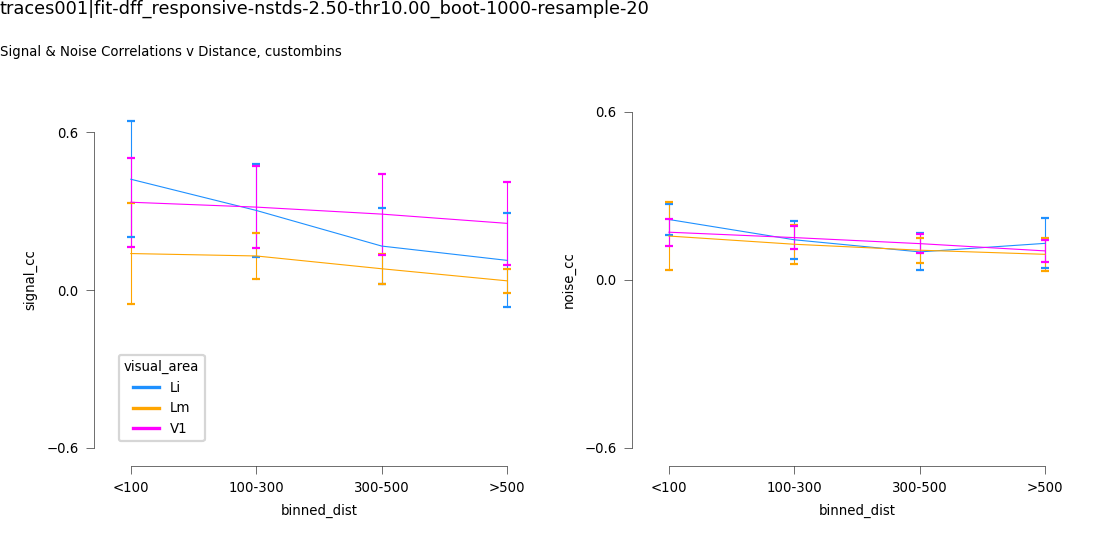

Text(0, 0.9, 'Signal & Noise Correlations v Distance, custombins')

In [855]:
lw=0.5

fig, axn = pl.subplots( 1, 2, figsize=(7,3.5)) #, sharex=True, sharey=False)
for ax, metric in zip(axn.flat, ['signal_cc', 'noise_cc']):
    sns.lineplot(x='binned_dist', y=metric, data=mean_ccs, ax=ax,
             hue='visual_area', palette=area_colors, ci='sd', err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)
    #ax.set_xticks(list(range(len(bin_edges))))
    #ax.set_xticklabels([round(i) for i in bin_edges])
    #ax.set_ylim([-0.7, 0.7])
    ax.set_yticks(np.linspace(-0.6, 0.6, 3)) #([-0.6, 0.6])
    sns.despine(offset=8, trim=True, ax=ax)
    
ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.3, hspace=0.5)

pplot.label_figure(fig, data_id)
fig.text(0, 0.9, 'Signal & Noise Correlations v Distance, %s' % bin_type)
# figname = 'sigcorrs_by_dist__%s_%s' % (stimulus_type, roi_filter)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

# Compare difference in preferred dirs

In [1420]:
c_ = []
for (va, dk), cc_ in corrdist.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    gfit_ =  passg[(passg.visual_area==va) & (passg.datakey==dk)
                  & (passg['asi']>=0.2)].copy()
    gfit_.index = gfit_['cell'].values
    rois_ =  gfit_['cell'].unique()
    if len(rois_)==0:
        continue
    tmpc = cc_[cc_['cell_1'].isin(rois_) & cc_['cell_2'].isin(rois_)].copy()
    diff_theta = gfit_.loc[tmpc['cell_1']]['theta_pref'].values \
                    - gfit_.loc[tmpc['cell_2']]['theta_pref'].values
    v = diff_theta % 360.
    thetas_range = ((v - 180) % 360) - 180 # -180, 180
    #to_deg = np.array([np.rad2deg(i) for i in thetas_range])
    #print(min(to_deg), max(to_deg))
#     thetas_range = [ (theta + 90) % 360 if (90 <= theta < 360) \
#         else (((theta) % 90) + 90) % 360 for theta in v]
#     thetas_range = np.array([(t % 180.) - 180. if ((90<t<180) or (270<t<360)) \
#                      else (t % 180.) for t in v ])
    #thetas_range2 = (v + 180) % 180. # (0, 180)
    tmpc['pref_theta_diff'] = thetas_range #% 360. #% 180.
    c_.append(tmpc)
fitdist = pd.concat(c_, axis=0).reset_index(drop=True)

fitdist['pref_theta_diff'].min(), fitdist['pref_theta_diff'].max() # Range from -180 to 180

(-176.32653061224494, 176.32653061224494)

In [1421]:
fitdist

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,visual_area,datakey,cortical_distance,binned_dist,pref_theta_diff
0,172,187,-0.478374,172_187,0.044495,Li,20190314_JC070_fov1,217.661674,100-300,95.510204
1,172,216,0.727695,172_216,0.246881,Li,20190314_JC070_fov1,451.735098,300-500,-7.346939
2,172,220,0.783481,172_220,-0.004236,Li,20190314_JC070_fov1,456.918526,300-500,-7.346939
3,172,235,0.099065,172_235,-0.005421,Li,20190314_JC070_fov1,662.784857,>500,124.897959
4,172,253,0.135893,172_253,0.067974,Li,20190314_JC070_fov1,468.471708,300-500,-58.775510
...,...,...,...,...,...,...,...,...,...,...
18042,237,266,0.460840,237_266,0.240423,V1,20191006_JC110_fov1,172.559270,100-300,-161.632653
18043,237,313,0.504684,237_313,0.081655,V1,20191006_JC110_fov1,359.807776,300-500,51.428571
18044,245,266,0.708482,245_266,0.408278,V1,20191006_JC110_fov1,96.025434,<100,-168.979592
18045,245,313,0.457018,245_313,0.116141,V1,20191006_JC110_fov1,443.795066,300-500,44.081633


In [1422]:
# # Bin cortical distances for plotting
# -----------------------------------------------
# n_bins_dist = 5
# use_quartile=False
# bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
# print("binning: %s" % bin_type)
# if use_quartile:
#     fitdist['binned_dist'], bin_edges = pd.qcut(fitdist['cortical_distance'], \
#                                     n_bins_dist, labels=False, retbins=True)
# else:
#     fitdist['binned_dist'], bin_edges = pd.cut(fitdist['cortical_distance'], \
#                                      n_bins_dist,labels=False, retbins=True)

#fitdist['binned_dist'] = None
# bins_ = [0, 100, 200, 300, 400, 500, np.inf]
# dist_labels = ['<100', '100-200', '200-300', '300-400', '400-500', '>500']

bins_ = [0, 150, 300, 450, np.inf]
dist_labels=[]
for i, b in enumerate(bins_[0:-1]):
    if i==0:
        dist_labels.append('<%i' % bins_[i+1])
    elif i==len(bins_)-2:
        dist_labels.append('>%i' % bins_[-2])
    else:
        dist_labels.append('%i-%i' % (b, bins_[i+1]))
# dist_labels = ['<100', '100-300', '300-500', '>500']
print(dist_labels)
fitdist['binned_dist'] = pd.cut(x=fitdist['cortical_distance'], 
                                bins=bins_,labels=dist_labels)


['<150', '150-300', '300-450', '>450']


In [1434]:
# bin thetas
# -----------------------------------------------
#metric='abs_diff'
metric = 'pref_theta_diff'
if metric=='abs_diff':
    fitdist['abs_diff'] = np.abs(fitdist['pref_theta_diff'])
    bins_ = np.linspace(0, 180, 6)
    theta_labels = np.linspace(0, 180, 6)[0:-1]
    fitdist['binned_theta'] = pd.cut(x=fitdist['abs_diff'],
                                     bins=bins_, labels=theta_labels)
else:
    bins_ = [-np.inf]
    vmin=-180; vmax=180;
    n_steps = 10
    int_size = np.mean(np.diff(np.linspace(vmin, vmax, n_steps)))

    rg = np.linspace(vmin, vmax, n_steps) + int_size/2.
    bins_.extend(rg[0:-1])
    bins_.append(np.inf)
    theta_labels = np.linspace(vmin, vmax, n_steps)
    fitdist['binned_theta'] = pd.cut(x=fitdist['pref_theta_diff'],
                                     bins=bins_, labels=theta_labels)
print(bins_)
print(theta_labels)

[-inf, -160.0, -120.0, -80.0, -40.0, 0.0, 40.0, 80.0, 120.0, 160.0, inf]
[-180. -140. -100.  -60.  -20.   20.   60.  100.  140.  180.]


<IPython.core.display.Javascript object>


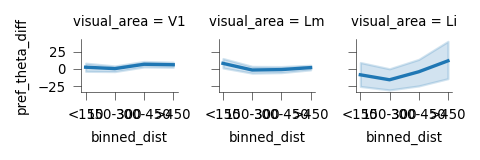

In [1435]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fitdist, height=1)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1436]:
# fitdist['abs_diff_rad'] = [np.deg2rad(i) for i in fitdist['abs_diff'].values]

# fitdist['binned_rad'] = [np.deg2rad(i) for i in fitdist['binned_theta'].values]

# print(fitdist['abs_diff_rad'].min(), fitdist['abs_diff_rad'].max())
# print(fitdist['binned_rad'].min(), fitdist['binned_rad'].max())
# fitdist.head()

In [1437]:
# Mean by FOV
mean_fitdist = fitdist.groupby(
                ['visual_area', 'datakey', 'binned_dist', 'binned_theta'])\
                .mean().reset_index().dropna()
mean_fitdist.head()
# cols = ['visual_area', 'datakey', 'binned_dist', 'binned_rad', 'abs_diff_rad']
# groups = ['visual_area', 'datakey', 'binned_dist', 'binned_rad']
# mean_fitdist = fitdist[cols].groupby(groups)\
#                         .apply(spstats.circmean, 
#                         high=np.pi, low=0, nan_policy='omit').reset_index()\
#                         .rename(columns={0: 'abs_diff_rad'})
# mean_fitdist['abs_diff'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['abs_diff_rad'].values]
# mean_fitdist['binned_theta'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['binned_rad'].values]

,visual_area,datakey,binned_dist,binned_theta,cell_1,cell_2,signal_cc,noise_cc,cortical_distance,pref_theta_diff,abs_diff
40,Li,20190314_JC070_fov1,<150,-180.0,297.0,318.0,0.050655,0.433490,107.332928,-176.326531,176.326531
41,Li,20190314_JC070_fov1,<150,-140.0,279.0,297.0,-0.149087,-0.083493,107.157176,-154.285714,154.285714
43,Li,20190314_JC070_fov1,<150,-60.0,218.0,253.0,0.293214,0.181292,101.372948,-51.428571,51.428571
44,Li,20190314_JC070_fov1,<150,-20.0,254.0,270.5,0.541135,0.144238,93.358755,-18.367347,18.367347
51,Li,20190314_JC070_fov1,150-300,-140.0,211.0,259.5,-0.128815,0.023185,271.443274,-154.285714,154.285714


In [1438]:
# d_=[]
# for (va, dk, b_dist, b_theta), g in fitdist.groupby(
#         ['visual_area', 'datakey', 'binned_dist', 'binned_theta']):
#     cells_in_bin = np.union1d(g['cell_1'].unique(), g['cell_2'].unique())
#     df_ = pd.DataFrame({'cell': cells_in_bin})
#     df_['visual_area'] = va
#     df_['datakey'] = dk
#     df_['binned_dist'] = b_dist
#     df_['binned_theta'] = b_theta
#     d_.append(df_)
# cells_in_bin = pd.concat(d_)

In [1439]:
# meanfit = fitdist.groupby(
#             ['visual_area', 'datakey', 'binned_dist'])['abs_diff']\
#             .mean().dropna().reset_index()
# meanfit.groupby(['visual_area', 'binned_dist']).mean()

<IPython.core.display.Javascript object>


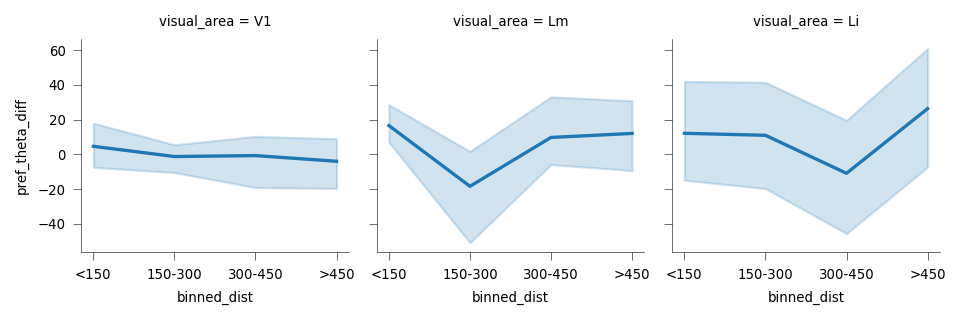

In [1440]:
meanfit = fitdist.groupby(
            ['visual_area', 'datakey', 'binned_dist'])[metric]\
            .mean().dropna().reset_index()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=meanfit, height=2)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1441]:
counts = fitdist.groupby(['visual_area', 'binned_dist', 'binned_theta'])\
            ['neuron_pair'].count().reset_index()\
        .rename(columns={'neuron_pair': 'n_theta_bin'})
counts
counts['n_dist_bin'] = None
for (va, bd), g in counts.groupby(['visual_area', 'binned_dist']):
    counts.loc[g.index, 'n_dist_bin'] = g['n_theta_bin'].sum()
counts['fraction'] = counts['n_theta_bin'] / counts['n_dist_bin'].astype(float)

<IPython.core.display.Javascript object>


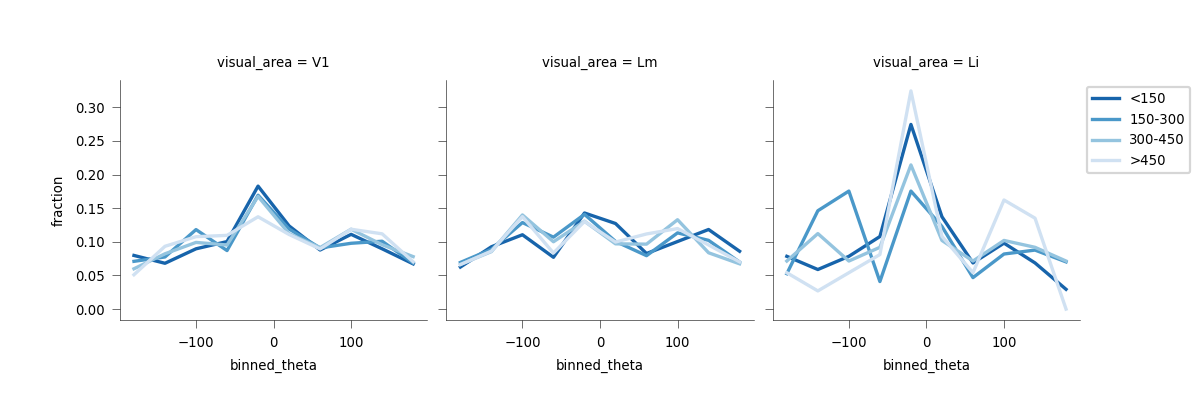

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [1442]:
dist_c = sns.color_palette('Blues_r', n_colors=len(dist_labels))
dist_colors = dict((k, v) for k, v in zip(dist_labels, dist_c))

#{'<150': 'b', '150-300': 'g', '300-450': 'r', '>450': 'k'}
plotd = counts.copy() #[counts['binned_dist']!='>450']
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=plotd,
                  height=2.5)
fg.map(sns.lineplot, 'binned_theta', 'fraction', 'binned_dist',
      palette=dist_colors)

pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

<IPython.core.display.Javascript object>


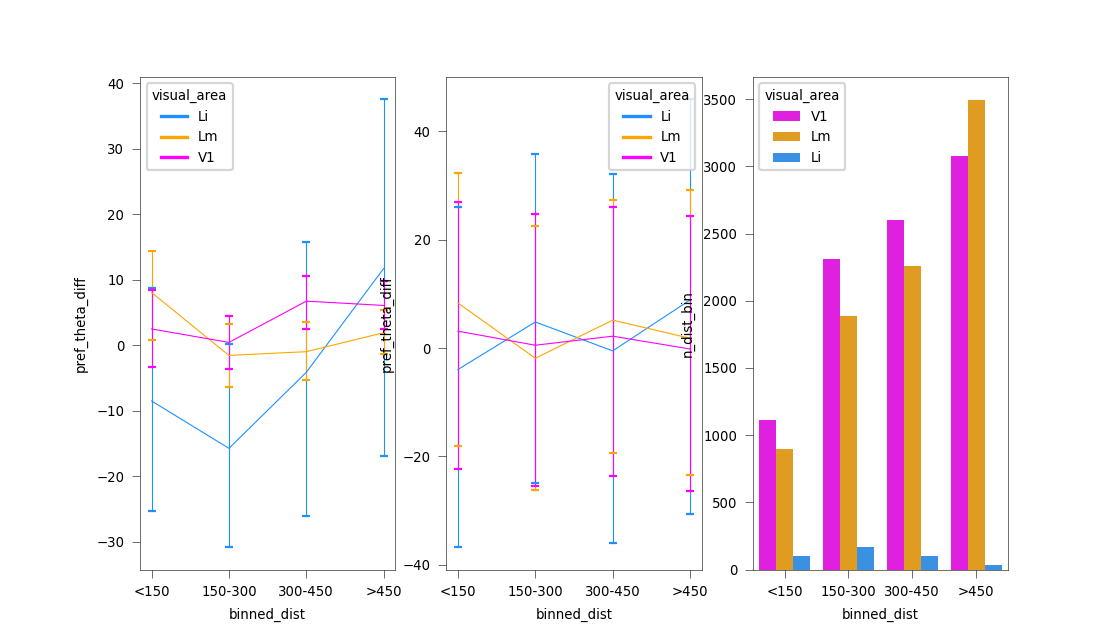

<AxesSubplot:xlabel='binned_dist', ylabel='n_dist_bin'>

In [1443]:
lw=0.5

fig, axn = pl.subplots(1,3,figsize=(7,4)) #, sharex=True, sharey=False)
# metric='abs_diff'
# metric = 'pref_deg_diff'
ax=axn[0]
sns.lineplot(x='binned_dist', y=metric, data=fitdist, ax=ax,
             hue='visual_area', palette=area_colors, ci=95,
             err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)

ax=axn[1]
sns.lineplot(x='binned_dist', y=metric, data=mean_fitdist, ax=ax,
             hue='visual_area', palette=area_colors, ci=95,
             err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)

ax=axn[2]
plotd = counts[['visual_area', 'binned_dist', 'n_dist_bin']].drop_duplicates()
sns.barplot(x='binned_dist', y='n_dist_bin', data=plotd, ax=ax,
           hue='visual_area', palette=area_colors, hue_order=visual_areas)